# GLM: Linear regression

In this example, we will start with the simplest GLM -- linear regression.
In general, frequentists think about linear regression as follows:

$$ Y = X\beta + \epsilon $$

where $Y$ is the output we want to predict (or *dependent* variable), $X$ is our predictor (or *independent* variable), and $\beta$ are the coefficients (or parameters) of the model we want to estimate. $\epsilon$ is an error term which is assumed to be normally distributed. 

We can then use ordinary least squares (OLS) or maximum likelihood to find the best fitting $\beta$.

## Probabilistic Reformulation

Bayesians take a probabilistic view of the world and express this model in terms of probability distributions. Our above linear regression can be reformulated as:

$$ Y \sim \mathcal{N}(X \beta, \sigma^2) $$

In words, we view $Y$ as a random variable (or random vector) of which each element (data point) is distributed according to a Normal distribution. The mean of this normal distribution is provided by our linear predictor with variance $\sigma^2$.

While this is essentially the same model, there are two critical advantages of Bayesian estimation:

 - Priors: We can quantify any prior knowledge we might have by placing priors on the parameters. For example, if we think that $\sigma$ is likely to be small we would choose a prior with more probability mass on low values.
 - Quantifying uncertainty: We do not get a single estimate of $\beta$ as above but instead a complete posterior distribution about how likely different values of $\beta$ are. For example, with few data points our uncertainty in $\beta$ will be very high and we'd be getting very wide posteriors.

## Bayesian GLMs in PyMC

To get started building GLMs in PyMC, let's first import the required modules.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
from pymc import HalfCauchy, Model, Normal, sample

print(f"Running on PyMC v{pm.__version__}")
# Running on PyMC v5.15.1+68.gc0b060b98.dirty

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.12.0


In [2]:
# globals
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

### Generating (true) data

Essentially we are creating a regression line defined by intercept and slope and add data points by sampling from a Normal with the mean set to the regression line.

In [3]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame({"x": x, "y": y})

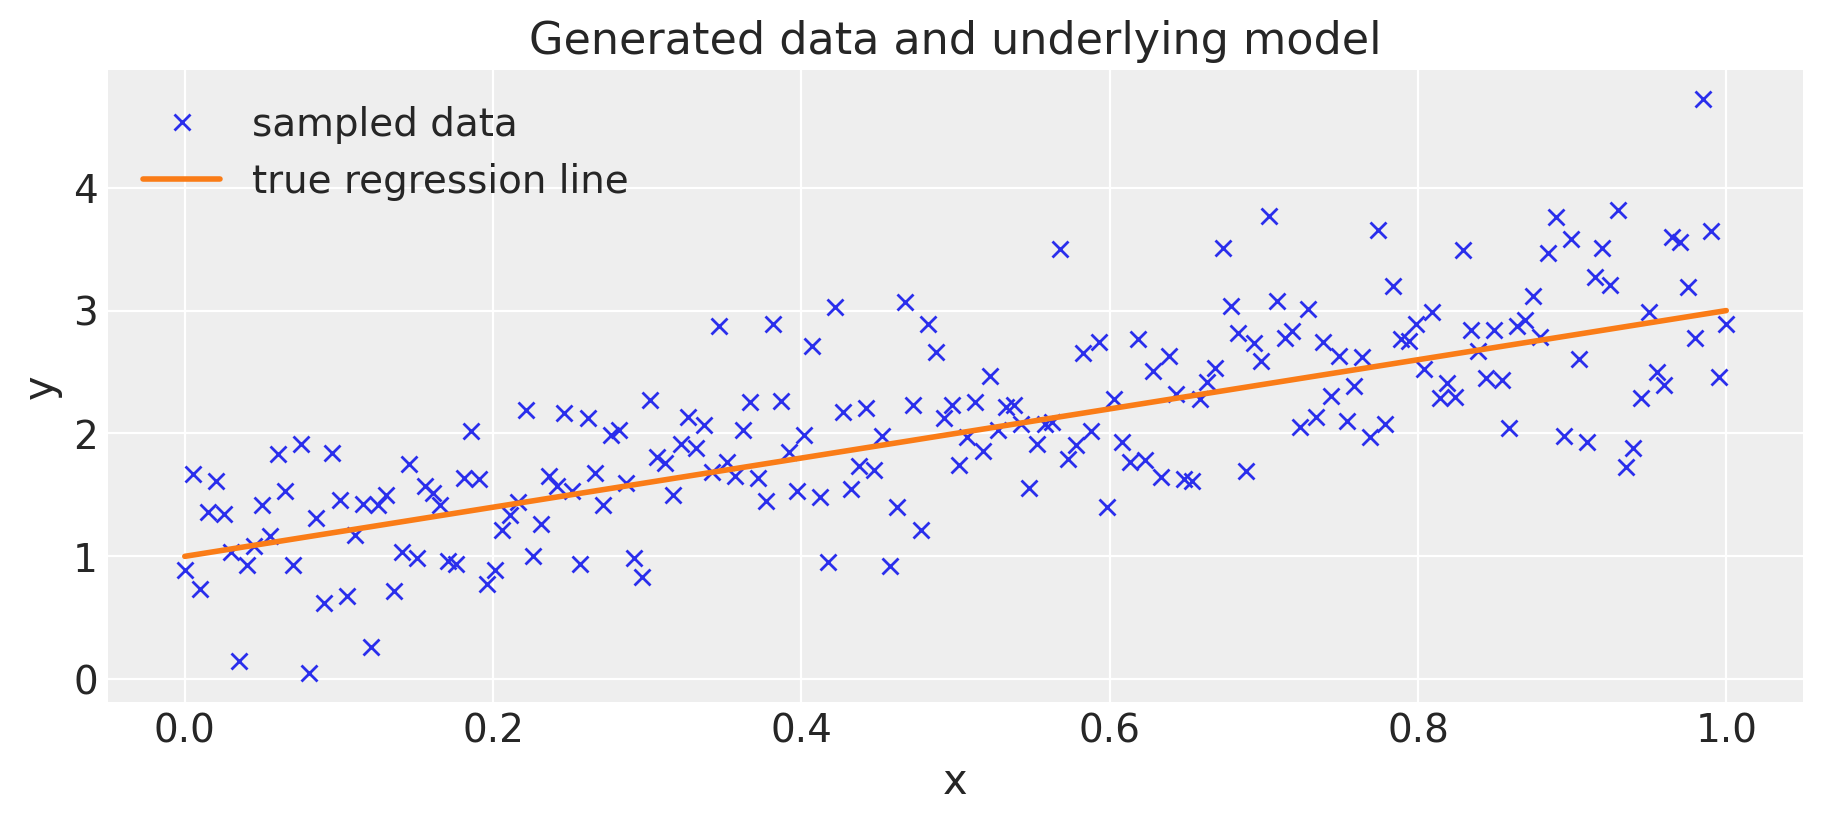

In [4]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

### Estimating the model

Lets fit a Bayesian linear regression model to this data. In PyMC, the model specifications takes place in a `with` expression, called a context manager. By default, models are fit using the [NUTS sampler](http://arxiv.org/abs/1111.4246), resulting in a trace of samples representing the marginal posterior distribution of the latent model parameters.

In [5]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy("sigma", beta=10)
    intercept = Normal("Intercept", 0, sigma=20)
    slope = Normal("slope", 0, sigma=20)

    # Define likelihood
    likelihood = Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 402 seconds.


### Analyzing the model

Bayesian inference does not give us only one line of best fit (as OLS or maximum likelihood do) but rather a whole posterior distribution of plausible parameters. Lets plot the posterior distribution of our parameters and the individual samples we drew.

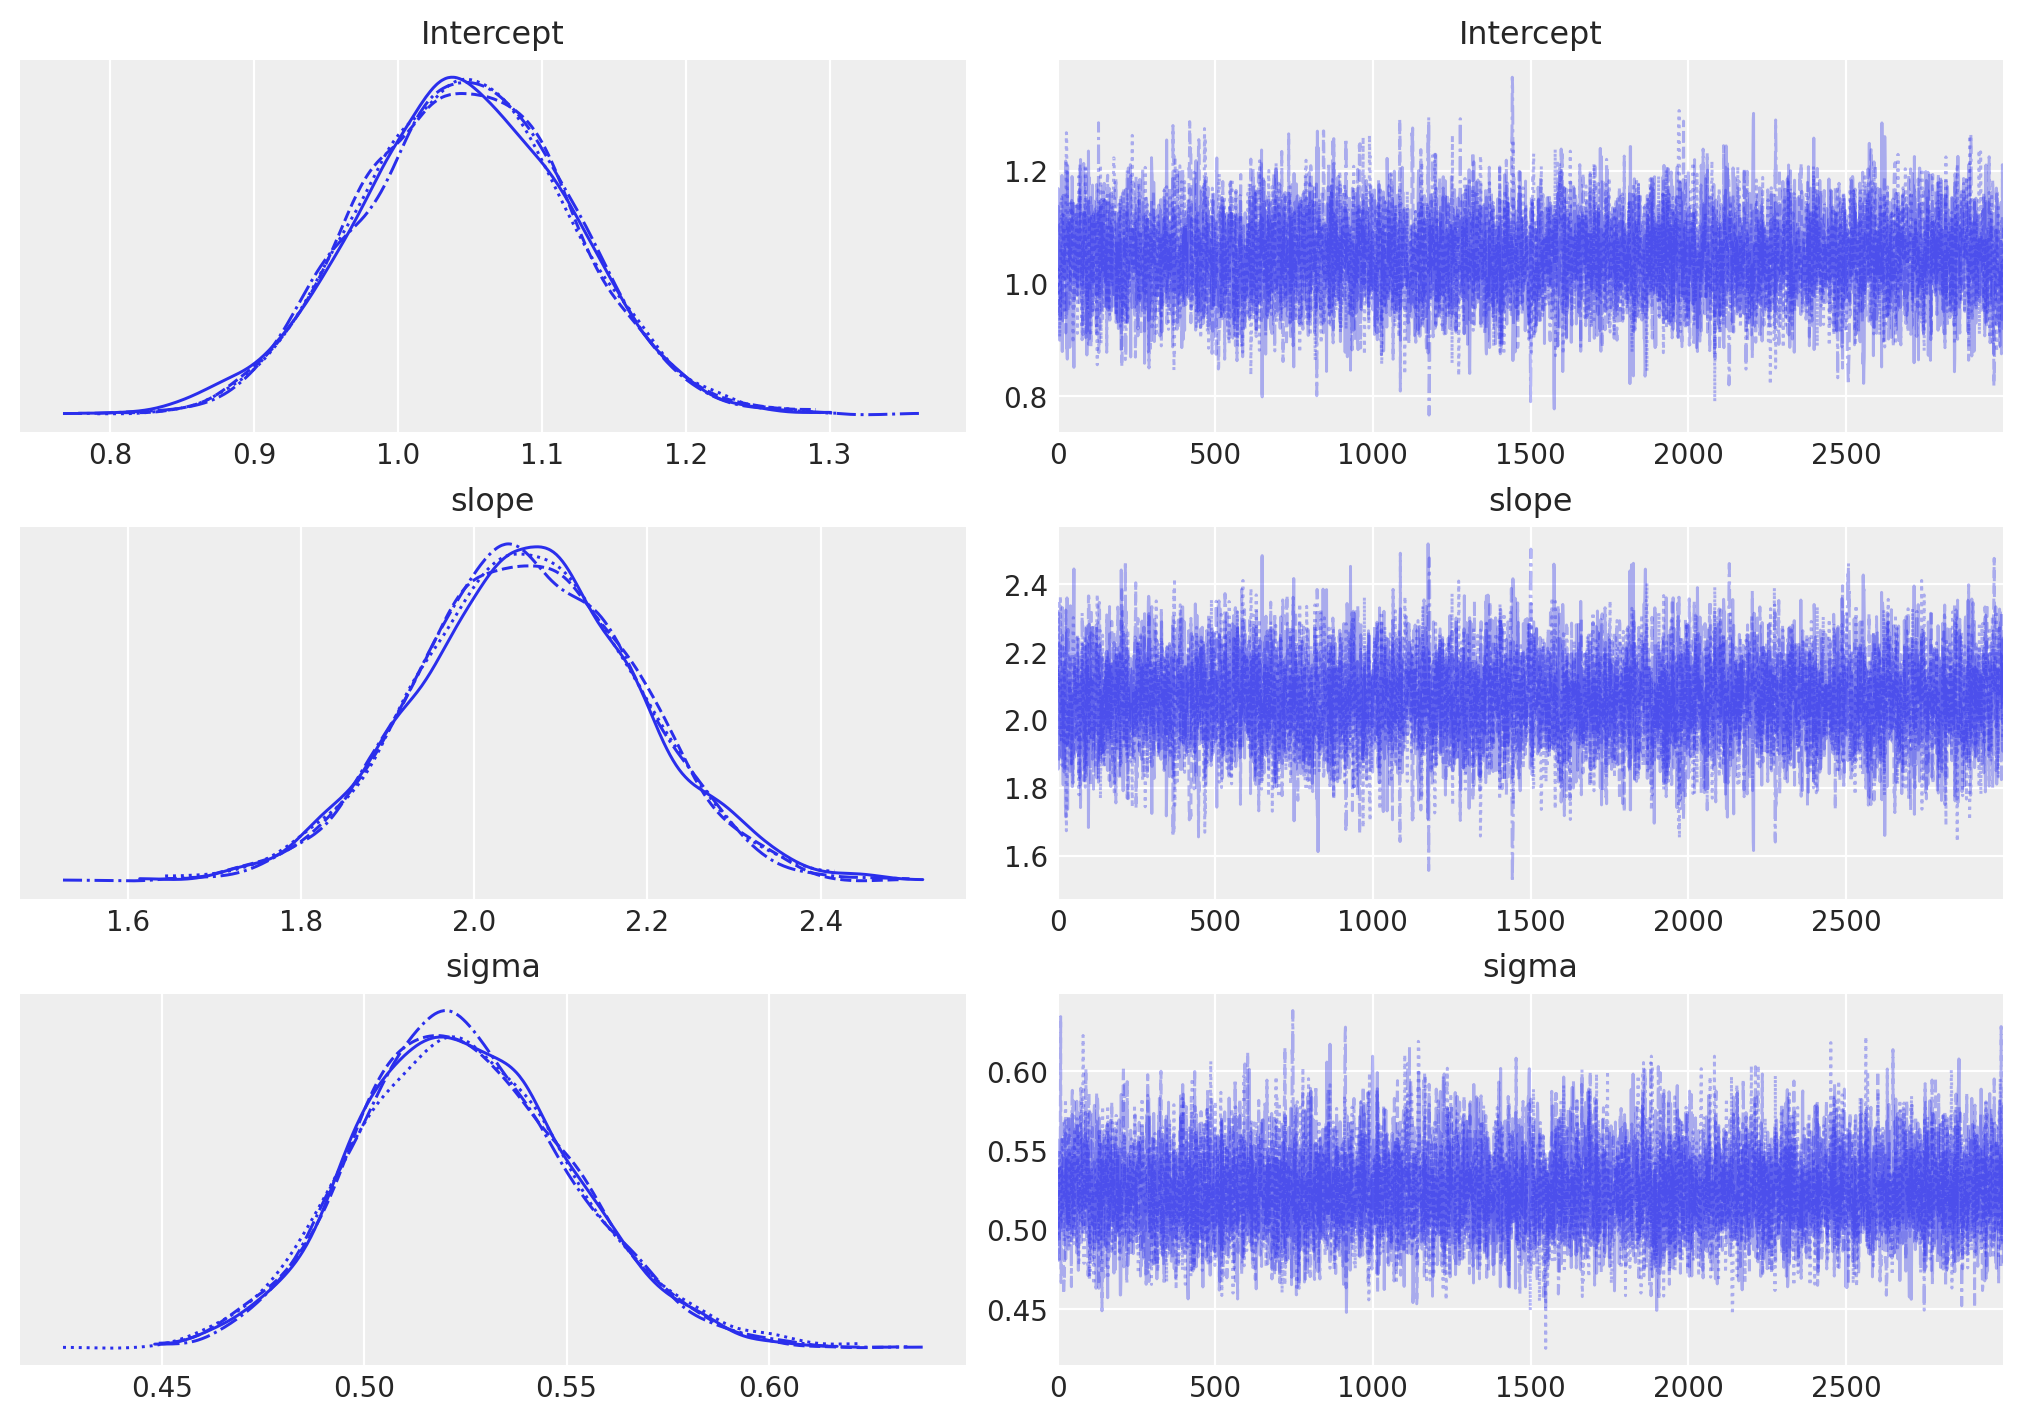

In [6]:
az.plot_trace(idata, figsize=(10, 7));

The left side shows our marginal posterior for each parameter value. On the x-axis we get the parameter value and on the y-axis its probability. 

There are a couple of things to see here. The first is that our sampling chains for the individual parameters (left side) seem homogeneous and stationary (there are no large drifts or other odd patterns).

Secondly, the maximum posterior estimate of each variable (the peak in the left side distributions) is very close to the true parameters used to generate the data (`x` is the regression coefficient and `sigma` is the standard deviation of our normal).

In GLMs, we thus do not only have one best fitting regression line, but many. A posterior predictive plot takes multiple samples from the posterior (intercepts and slopes) and plots a regression line for each of them. We can manually generate these regression lines using the posterior samples directly.

In [8]:
idata.posterior["y_model"] = idata.posterior["Intercept"] + idata.posterior["slope"] * xr.DataArray(x)

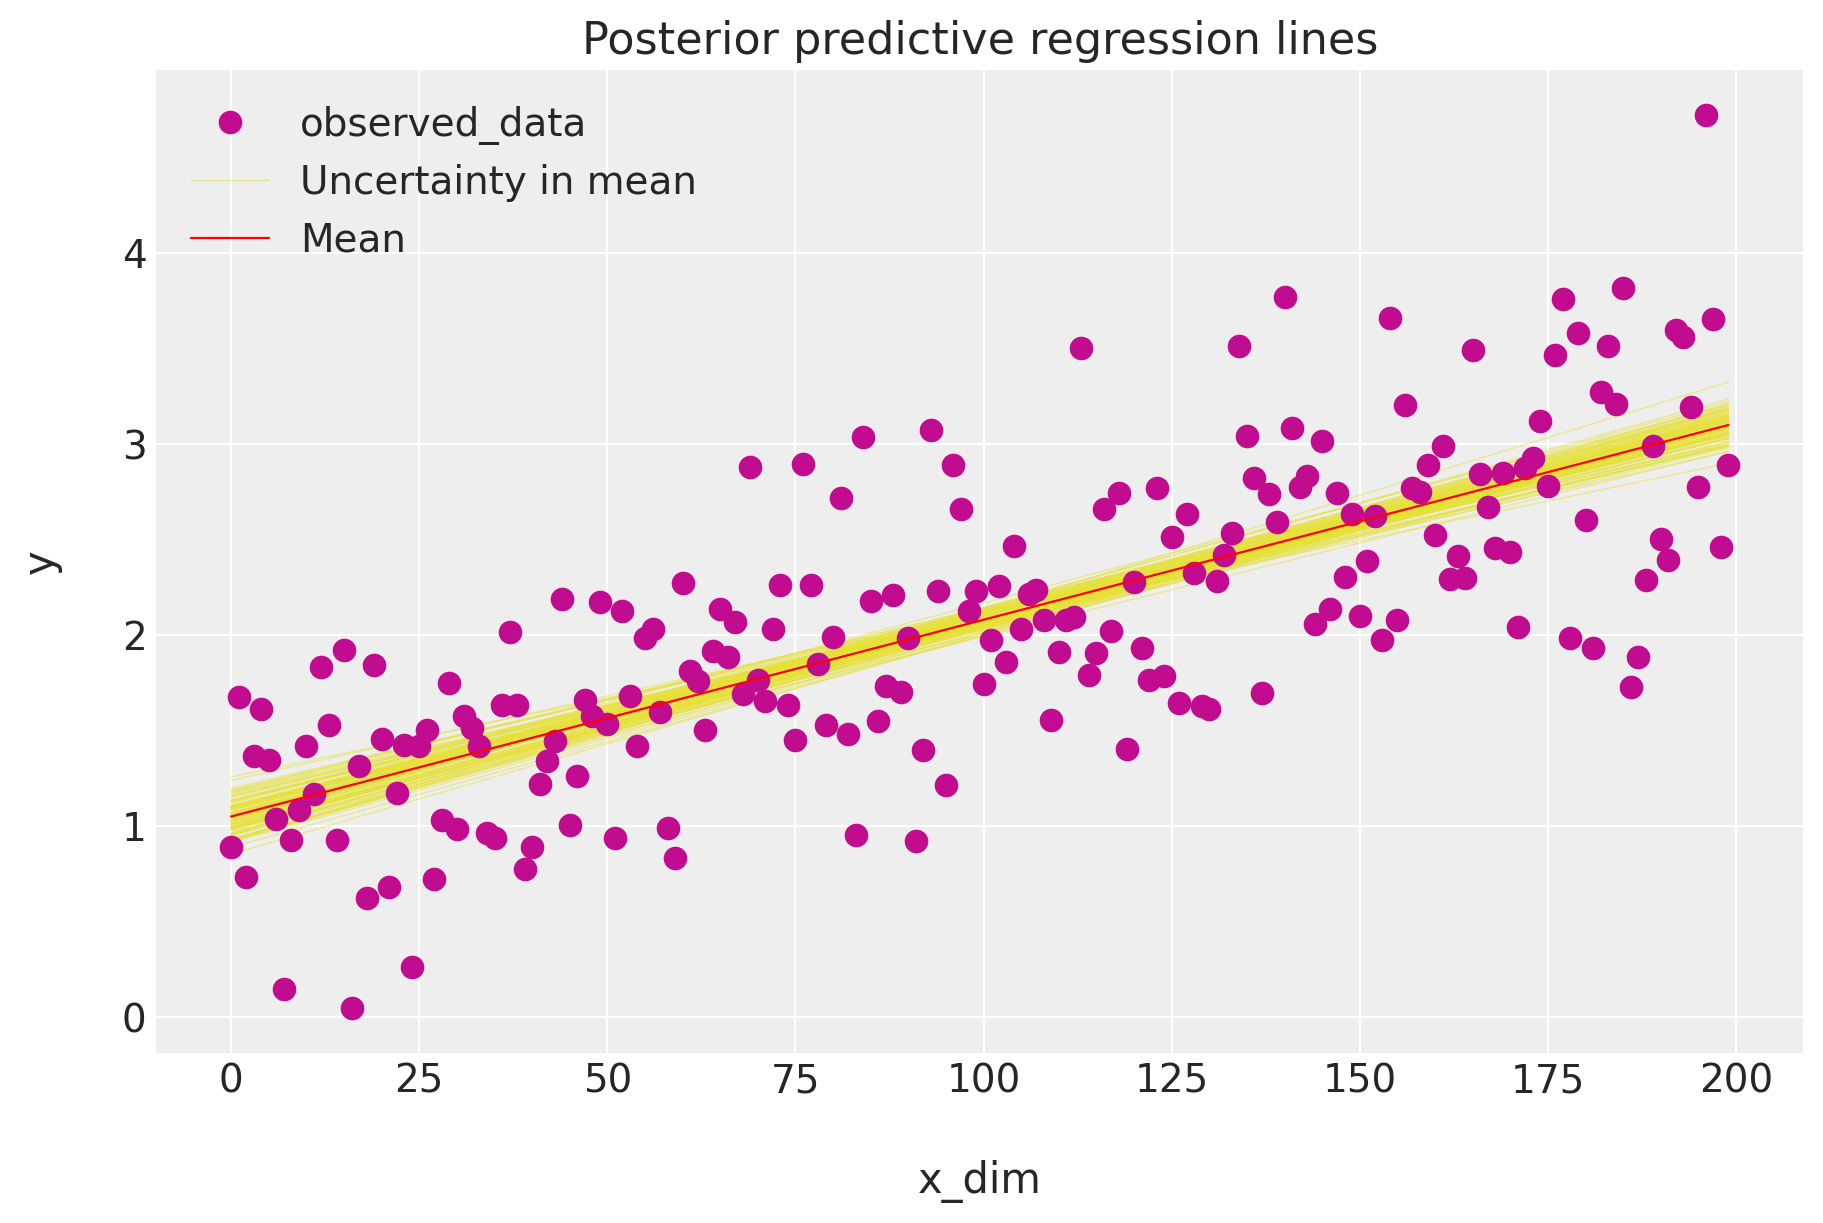

In [46]:
_, ax = plt.subplots(figsize=(9, 6))
az.plot_lm(idata=idata, y="y", num_samples=100, axes=ax, y_model="y_model")
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("\nx_dim");
ax.set_ylabel("y\n");
handles, labels = ax.get_legend_handles_labels()
# Modify the legend
handles, labels = ax.get_legend_handles_labels()
for i, label in enumerate(labels):
    if "Mean" in label:
        handles[i].set_color('red')  # Change legend color
ax.legend(handles, labels)

As you can see, our estimated regression lines are very similar to the true regression line. But since we only have limited data we have *uncertainty* in our estimates, here expressed by the variability of the lines.

## Summary

 - Posterior predictive plots allow us to evaluate fit and our uncertainty in it.